## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that we get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape[0]

294478

In [4]:
df.user_id.nunique()

290584

In [5]:
# The proportion of users converted

df.query('converted == 1').converted.count()/ df.shape[0]

0.11965919355605512

In [6]:
# The number of times the `new_page` and `treatment` don't match.

con = df.query('group == "control" & landing_page =="new_page"').count()
tr = df.query('group == "treatment" & landing_page =="old_page"').count()

con + tr

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

In [8]:
df2 = df.drop(df[(df.group == 'control') & (df.landing_page == 'new_page')].index)
df2.drop(df2[(df2.group == 'treatment') & (df.landing_page == 'old_page')].index, inplace = True)

df2.head()

<ipython-input-8-192853109e1f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2.drop(df2[(df2.group == 'treatment') & (df.landing_page == 'old_page')].index, inplace = True)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
# How many unique user_ids are in df2?

df2.user_id.nunique()

290584

In [11]:
# There is one user_id repeated in df2.  What is it?

df2.user_id.value_counts().head()

773192    2
630836    1
634271    1
753093    1
751044    1
Name: user_id, dtype: int64

In [12]:
# What is the row information for the repeat user_id? 

df2.query("user_id == 773192")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
# Remove one of the rows with a duplicate user_id.

df2.drop_duplicates(subset = 'user_id', inplace = True)

In [14]:
# What is the probability of an individual converting regardless of the page they receive?

df2.converted.mean()

0.11959708724499628

In [15]:
# Given that an individual was in the `control` group, what is the probability they converted?

df2.query("group == 'control'").converted.mean()

0.1203863045004612

In [16]:
# Given that an individual was in the `treatment` group, what is the probability they converted?

df2.query("group == 'treatment'").converted.mean()

0.11880806551510564

In [17]:
# the probability that an individual received the new page

df2.query("landing_page == 'new_page'").count() / df2.shape[0]

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

e. Consider results from parts (a) through (d) above, and explain below whether there is sufficient evidence to conclude that the new treatment page leads to more conversions:

No. The conversion rate of control group is actually higher than the one of treatment group. Considering there are almost the same number of participants in each group, we can assume the number of conversion would be similar as well, not just conversion "rates". Also, there is no evidence to support the idea that new treatment page leads to more conversions.

Null hypothesis (H0): **$p_{old}$** - **$p_{new}$** >= 0

Althernative hypothesis (H1): **$p_{old}$** - **$p_{new}$** < 0

`2.` Let's assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. 

In [18]:
# conversion rate for p_new under the null

p_new = df2.converted.mean()
p_new

0.11959708724499628

In [19]:
# conversion rate for p_old under the null

p_old = df2.converted.mean()
p_old

0.11959708724499628

In [20]:
# the number of individuals in the treatment group

n_new = df2.query("group == 'treatment'").user_id.nunique()
n_new

145310

In [21]:
# the number of individuals in the control group

n_old = df2.query("group == 'control'").user_id.nunique()
n_old

145274

In [22]:
# Let's simulate n_new transactions with a conversion rate of p_new under the null

new_page_converted = np.random.choice([0,1], n_new, [p_new, 1-p_new])
print(new_page_converted)

[1 0 1 ... 1 1 0]


In [23]:
# Simulate n_old transactions with a conversion rate of p_old under the null

old_page_converted = np.random.choice([0,1], n_old, [p_old, 1-p_old])
print(old_page_converted)

[0 0 1 ... 1 0 0]


In [24]:
# Find p_new - p_old for stimulated values

diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0014727169197933931

In [25]:
# Create 10,000 p_new - p_old values using the same simulation process

p_diffs = []
for _ in range (10000):
    old_page = np.random.binomial(1, p_old, n_old)
    new_page = np.random.binomial(1, p_new, n_new)
    diff = np.mean(new_page) - np.mean(old_page)
    p_diffs.append(diff)

p_diffs = np.array(p_diffs)

In [26]:
# actual difference

diff_obs = df2.query("group == 'treatment'").converted.mean() - df2.query("group == 'control'").converted.mean()
diff_obs

-0.0015782389853555567

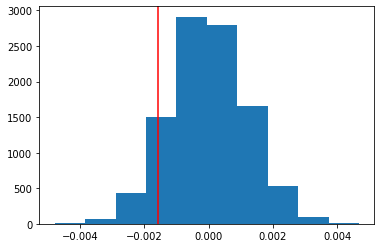

In [27]:
plt.hist(p_diffs)
plt.axvline(x= diff_obs, color = 'r');

In [28]:
# proportion of the p_diffs are greater than the actual difference observed

(p_diffs > diff_obs).mean()

0.906

This value is called p-value, which tells us the probability of getting an observed value under null hypothesis. Since it's bigger than alpha (usually 0.05) we don't have enough evidence to reject null hypothesis, which claims that there is no statistically significant difference in conversion rate between the old page and new page.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"').converted.sum()
convert_new = df2.query('landing_page == "new_page"').converted.sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

In [30]:
# calculating test statistic and p-value

count = [convert_new, convert_old]
nobs =  [n_new, n_old]

z_score , p_value = sm.stats.proportions_ztest(count, nobs, alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [31]:
from scipy.stats import norm

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))

1.6448536269514722


p-value is very close to the p-value that we calculated in question j. z-score is -1.3116, which is less than the critical value of 1.64485362695 for upper-tail test with 95% confidence level. We can only reject the null hypothesis if Z is larger than the critical value of 1.64485362695. The results of z-test also shows that there is no significant difference in the conversion rates between new pages and old pages.




### Part III - A regression approach
Since each row is either a conversion or no conversion, logistic regression must be performing in this case.

In [32]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop('control', inplace = True, axis = 1)
df2.tail()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0,1,1


In [33]:
# instantiate & fit the regression model

import statsmodels.api as sm

df2_logit = sm.Logit(df2['converted'], df2[['ab_page', 'intercept']])
df2_fit = df2_logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [34]:
df2_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-04-25 19:04 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
==================================================================

"""

p-value associated to ab-page is 0.1899. Null hypothesis in Part 3 (logistic regression) is 
p_old - p_new = 0 (two-tailed), which is different from the one in Part 2, 
p_old - p_new >= 0 (one-tailed) based on a sampling distribution approach. Null hypothesis in Part 3 is that there the new page has no significant impact to the conversion rates.

Since p-value for ab_page is bigger than 0.05 (critical value), ab_page can't explain whether or not an indiviaul concerts. On the other hand, other variables could be helpful in understanding our regression model, by letting us see if controlling for these variables affects the coefficient of ab_page. Therefore we can add those variables to our initial regression model to control for their influence.

In [35]:
df = pd.read_csv('countries.csv')
df_all = df.set_index('user_id').join(df2.set_index('user_id'), on= 'user_id', how= 'inner')
df_all.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [36]:
df_all[['UK','US']]= pd.get_dummies(df_all['country'])[['UK','US']]
df_all.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [37]:
df_all['intercept'] = 1
df_logit = sm.Logit(df_all['converted'], df_all[['intercept', 'UK', 'US', 'ab_page']])
df_fit = df_logit.fit()
df_fit.summary2()                                 

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-04-25 19:04 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""

In [38]:
np.exp(df_fit.params)

intercept    0.131332
UK           1.051944
US           1.041599
ab_page      0.985168
dtype: float64

Because p-value for every variable exceed 0.05, country and ab_page give no significant impact to the conversion rates. Instead, from coefficients, we know that the conversion rate of UK users are 1.051944 times higher than Canada users, and the one from US users are 1.041593 times higher than Canada users.

